In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('trip_count_sql').getOrCreate()

directory = '/home/ubuntu/working/spark-examples/data'
trip_files = 'trips/'

trips_df = spark.read.csv(f'file://{directory}/{trip_files}',
                         inferSchema = True,
                         header = True)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2023-06-16 03:36:47,607 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
trips_df.createOrReplaceTempView('trips')

19번 notebook에서 했던 회귀 분석과 달라진 점.
- 데이터가 너무 적었기 때문에

In [3]:
query = """
SELECT 
    passenger_count,
    PULocationID as pickup_location_id,
    DOLocationID as dropoff_location_id,
    trip_distance,
    HOUR(tpep_pickup_datetime) as pickup_time,
    DATE_FORMAT(TO_DATE(tpep_pickup_datetime), 'EEEE') AS day_of_week,
    total_amount
FROM
    trips
WHERE
    total_amount < 5000
    AND total_amount > 0
    AND trip_distance > 0
    AND trip_distance < 500
    AND passenger_count < 4
    AND TO_DATE(tpep_pickup_datetime) >= '2021-01-01'
    AND TO_DATE(tpep_pickup_datetime) < '2021-08-01'
"""
data_df = spark.sql(query)
data_df.createOrReplaceTempView("data")

In [4]:
data_df.show()

+---------------+------------------+-------------------+-------------+-----------+-----------+------------+
|passenger_count|pickup_location_id|dropoff_location_id|trip_distance|pickup_time|day_of_week|total_amount|
+---------------+------------------+-------------------+-------------+-----------+-----------+------------+
|              0|               138|                265|         16.5|          0|     Monday|       70.07|
|              1|                68|                264|         1.13|          0|     Monday|       11.16|
|              1|               239|                262|         2.68|          0|     Monday|       18.59|
|              1|               186|                 91|         12.4|          0|     Monday|        43.8|
|              2|               132|                265|          9.7|          0|     Monday|        32.3|
|              1|               138|                141|          9.3|          0|     Monday|       43.67|
|              1|           

In [5]:
data_df.printSchema()

root
 |-- passenger_count: integer (nullable = true)
 |-- pickup_location_id: integer (nullable = true)
 |-- dropoff_location_id: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_time: integer (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- total_amount: double (nullable = true)



- pickup_loaction_id, dropoff_location_id, day_of_week: 카테고리 데이터
- 기타: standard scaling

In [6]:
train_df, test_df = data_df.randomSplit([0.8,0.2], seed = 42)

In [7]:
train_df.count(), len(train_df.columns)

(10500692, 7)

지금처럼 데이터의 양이 너무나 많고, 그 데이터에 대한 전처리를 수행했음.
그래서 시간이 굉장히 많이 걸렸다고 가정합시다.

- 사용할 데이터 마트의 구축이 완료된 상황이라 가정
- 추후에 다시 이 데이터를 다시 활용한다면 다시 처음부터 전처리하는데 시간 많이 걸림
- 이렇게 전처리가 된 데이터를 파일이나 데이터베이스에 저장해놓고, 나중에 다시 불러오는게 훨씬 시간적으로 이득


- 파케이(parquet) 형식으로 데이터 마트를 저장
    - 하둡에서 사용되는 방식
    - 열 기반 압축 방식


In [7]:
# - 파케이(parquet) 형식으로 데이터 마트를 저장
data_dir = "/home/ubuntu/working/spark-examples/data/ml-data"

# Spark Dataframe의 write를 이용해 데이터를 파일 또는 데이터베이스에 저장이 가능
train_df.write.format('parquet').save(f'{data_dir}/train/') # parquet라는 형식으로 저장할게요.
test_df.write.format('parquet').save(f'{data_dir}/test/')

Py4JJavaError: An error occurred while calling o41.save.
: java.net.ConnectException: Call From ip-172-31-38-79/172.31.38.79 to ip-172-31-38-79.ap-northeast-3.compute.internal:9000 failed on connection exception: java.net.ConnectException: Connection refused; For more details see:  http://wiki.apache.org/hadoop/ConnectionRefused
	at java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
	at java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:490)
	at org.apache.hadoop.net.NetUtils.wrapWithMessage(NetUtils.java:913)
	at org.apache.hadoop.net.NetUtils.wrapException(NetUtils.java:828)
	at org.apache.hadoop.ipc.Client.getRpcResponse(Client.java:1577)
	at org.apache.hadoop.ipc.Client.call(Client.java:1519)
	at org.apache.hadoop.ipc.Client.call(Client.java:1416)
	at org.apache.hadoop.ipc.ProtobufRpcEngine2$Invoker.invoke(ProtobufRpcEngine2.java:242)
	at org.apache.hadoop.ipc.ProtobufRpcEngine2$Invoker.invoke(ProtobufRpcEngine2.java:129)
	at com.sun.proxy.$Proxy27.getFileInfo(Unknown Source)
	at org.apache.hadoop.hdfs.protocolPB.ClientNamenodeProtocolTranslatorPB.getFileInfo(ClientNamenodeProtocolTranslatorPB.java:965)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at org.apache.hadoop.io.retry.RetryInvocationHandler.invokeMethod(RetryInvocationHandler.java:422)
	at org.apache.hadoop.io.retry.RetryInvocationHandler$Call.invokeMethod(RetryInvocationHandler.java:165)
	at org.apache.hadoop.io.retry.RetryInvocationHandler$Call.invoke(RetryInvocationHandler.java:157)
	at org.apache.hadoop.io.retry.RetryInvocationHandler$Call.invokeOnce(RetryInvocationHandler.java:95)
	at org.apache.hadoop.io.retry.RetryInvocationHandler.invoke(RetryInvocationHandler.java:359)
	at com.sun.proxy.$Proxy28.getFileInfo(Unknown Source)
	at org.apache.hadoop.hdfs.DFSClient.getFileInfo(DFSClient.java:1731)
	at org.apache.hadoop.hdfs.DistributedFileSystem$29.doCall(DistributedFileSystem.java:1752)
	at org.apache.hadoop.hdfs.DistributedFileSystem$29.doCall(DistributedFileSystem.java:1749)
	at org.apache.hadoop.fs.FileSystemLinkResolver.resolve(FileSystemLinkResolver.java:81)
	at org.apache.hadoop.hdfs.DistributedFileSystem.getFileStatus(DistributedFileSystem.java:1764)
	at org.apache.hadoop.fs.FileSystem.exists(FileSystem.java:1760)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:117)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:113)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:111)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:125)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:97)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:97)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:93)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:481)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:82)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:481)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:457)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:93)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:80)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:78)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:115)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:848)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:382)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:355)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:239)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.net.ConnectException: Connection refused
	at java.base/sun.nio.ch.SocketChannelImpl.checkConnect(Native Method)
	at java.base/sun.nio.ch.SocketChannelImpl.finishConnect(SocketChannelImpl.java:777)
	at org.apache.hadoop.net.SocketIOWithTimeout.connect(SocketIOWithTimeout.java:206)
	at org.apache.hadoop.net.NetUtils.connect(NetUtils.java:586)
	at org.apache.hadoop.ipc.Client$Connection.setupConnection(Client.java:701)
	at org.apache.hadoop.ipc.Client$Connection.setupIOstreams(Client.java:822)
	at org.apache.hadoop.ipc.Client$Connection.access$3800(Client.java:414)
	at org.apache.hadoop.ipc.Client.getConnection(Client.java:1647)
	at org.apache.hadoop.ipc.Client.call(Client.java:1463)
	... 62 more


In [ ]:
!netstat -an | grep 9000

- data의 전통적인 저장 방식 -> 행 기반 압축
- 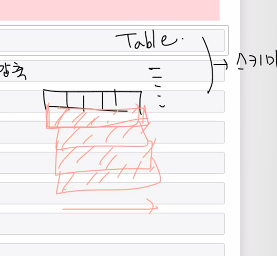

- parquet -> 열 기반
- 빅데이터는 column이 많음
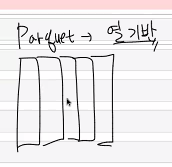

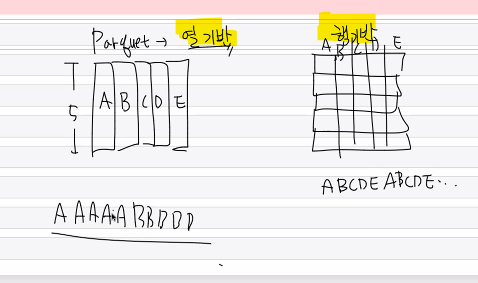
- 열기반: 데이터 직렬화 가능
- 데이터 저장 시
    - 행기반: ABCDEABCDE..
    - 열기반: AAAAABBBBBCCCCC  (데이터가져오기 수월)

In [24]:
# 분산 저장 되어서 파티션으로 분리된 파일을 불러오기
train_df = spark.read.parquet(f'file://{data_dir}/train/') # 여러개의 파일을 불러오는게 아니고 train이라는 파일을 불러오듯..?
test_df = spark.read.parquet(f'{data_dir}/test/')

In [25]:
train_df.printSchema()

root
 |-- passenger_count: integer (nullable = true)
 |-- pickup_location_id: integer (nullable = true)
 |-- dropoff_location_id: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_time: integer (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- total_amount: double (nullable = true)



# 파이프라인 구성

In [26]:
# pipeline에 넣을 과정(stage)을 하나씩 넣어 놓을 리스트 생성
stages = []

## 1. OneHotEncoding Stage
- `pickup_location_id` : integer
- `dropoff_location_id` : integer
- `day_of_week`: string
---
- `StringIndexer`: 숫자 데이터 -> string 
- 숫자 형태의 데이터는 OneHotEncoding이 안된다.
    - scikit learn에서는 integer도 원핫인코딩 가능했었다
    - 그러나 spark에서는 integer는 원핫인코딩 안되기때문에 문자열로 바꿔야.

- 숫자 형식의 카테고리 데이터를 임시로 문자열로 처리하기 위해 `StringIndexer` 트랜스포머를 활용

**stage**
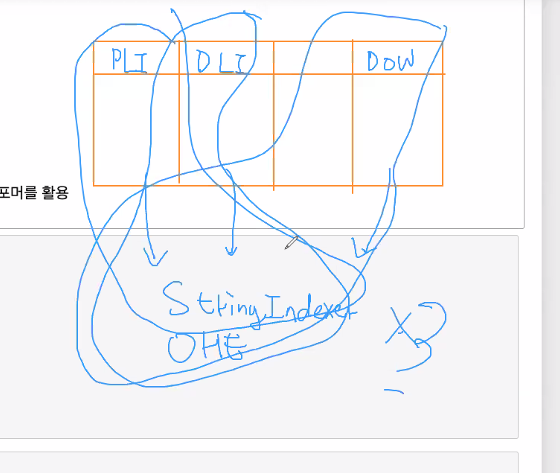

- cat_index를 지나면: pickup_location_id -> pickup_location_id_idx
- onehot encoder를 지나면 : pickup_location_id_idx -> pickup_location_id_onehot

In [27]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# OneHotEncoding을 수행할 컬럼을 지정
cat_features = ['pickup_location_id',
                'dropoff_location_id',
               'day_of_week']

for c in cat_features:
    # 1. 데이터를 문자열 형식으로 바꿔주기.
    # setHandleInvalid: Null값 같은 데이터를 어떻게 처리할건지? (keep: 유지하겠다.)
    cat_indexer = StringIndexer(inputCol=c, outputCol= c+'_idx').setHandleInvalid('keep')
    
    
    # 2. One Hot Encoding 수행
    onehot_encoder = OneHotEncoder(inputCols=[cat_indexer.getOutputCol()],outputCols=[c+'_onehot'])

    stages += [cat_indexer, onehot_encoder]
    
stages
    
# string -> oh encoding -> string -> oh encoding -> string -> oh encoding


[StringIndexer_a86a6c36fbb5,
 OneHotEncoder_40f6440c021b,
 StringIndexer_b633691568c0,
 OneHotEncoder_03472850a1b0,
 StringIndexer_d3dd983d8e0d,
 OneHotEncoder_8d00d69bf8d3]

['pickup_location_id_onehot',
                'dropoff_location_id_onehot',
               'day_of_week_onehot'] 컬럼이 추가된 것


## 2. StandardScaler & VectorAssembler Stage
- `passenger_count`
- `trip_distance`
- `pickup_time`

In [28]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

num_features = [
    'passenger_count',
    'trip_distance',
    'pickup_time'
]

for n in num_features:
    
    # 각각의 컬럼의 데이터가 벡터화. ex) 1.5 -> [1.5]
    num_assembler = VectorAssembler(inputCols=[n], outputCol=n+'_vector')
    
    # StandardScaling 수행
    num_scaler = StandardScaler(inputCol=num_assembler.getOutputCol(), outputCol=n+'_scaled')
    
    stages += [num_assembler, num_scaler]

stages


[StringIndexer_a86a6c36fbb5,
 OneHotEncoder_40f6440c021b,
 StringIndexer_b633691568c0,
 OneHotEncoder_03472850a1b0,
 StringIndexer_d3dd983d8e0d,
 OneHotEncoder_8d00d69bf8d3,
 VectorAssembler_942b8deba82d,
 StandardScaler_b0d56b3851c0,
 VectorAssembler_2431f5d42507,
 StandardScaler_80baf6546db2,
 VectorAssembler_71cf5cebae64,
 StandardScaler_9e1212a5fd7c]

- 위에까지는 머신러닝을 위한 preprocessing
- **머신러닝을 위한 Preprocessing된 결과물 벡터를 하나로 합쳐야 훈련 가능한 데이터가 된다 -> `VectorAssembler` 사용해서 합친다.**

### Assemble할 데이터

In [29]:
# Assemble 할 데이터는?
## OneHotEncoding이 되어있거나, scaled된 데이터를 합쳐줘야 한다. 

assembler_inputs = [c+"_onehot" for c in cat_features] + [n+'_scaled' for n in num_features]
assembler_inputs

['pickup_location_id_onehot',
 'dropoff_location_id_onehot',
 'day_of_week_onehot',
 'passenger_count_scaled',
 'trip_distance_scaled',
 'pickup_time_scaled']

In [30]:
total_assembler = VectorAssembler(inputCols=assembler_inputs, outputCol='features')
stages.append(total_assembler)

stages

[StringIndexer_a86a6c36fbb5,
 OneHotEncoder_40f6440c021b,
 StringIndexer_b633691568c0,
 OneHotEncoder_03472850a1b0,
 StringIndexer_d3dd983d8e0d,
 OneHotEncoder_8d00d69bf8d3,
 VectorAssembler_942b8deba82d,
 StandardScaler_b0d56b3851c0,
 VectorAssembler_2431f5d42507,
 StandardScaler_80baf6546db2,
 VectorAssembler_71cf5cebae64,
 StandardScaler_9e1212a5fd7c,
 VectorAssembler_c9d735530b08]

In [31]:
# 파이프라인 등록
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=stages)
pipeline

Pipeline_e57fa7c796c8

In [32]:
# fit

fitted_transformer = pipeline.fit(train_df) # 모델 생성 전. 전처리 pipeline
fitted_transformer

PipelineModel_5eb97a5c8f38

**transformer 파이프라인을 이용해 train_df 데이터 변환 확인**

In [33]:
vec_train_df = fitted_transformer.transform(train_df)
vec_train_df.printSchema()

root
 |-- passenger_count: integer (nullable = true)
 |-- pickup_location_id: integer (nullable = true)
 |-- dropoff_location_id: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_time: integer (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- pickup_location_id_idx: double (nullable = false)
 |-- pickup_location_id_onehot: vector (nullable = true)
 |-- dropoff_location_id_idx: double (nullable = false)
 |-- dropoff_location_id_onehot: vector (nullable = true)
 |-- day_of_week_idx: double (nullable = false)
 |-- day_of_week_onehot: vector (nullable = true)
 |-- passenger_count_vector: vector (nullable = true)
 |-- passenger_count_scaled: vector (nullable = true)
 |-- trip_distance_vector: vector (nullable = true)
 |-- trip_distance_scaled: vector (nullable = true)
 |-- pickup_time_vector: vector (nullable = true)
 |-- pickup_time_scaled: vector (nullable = true)
 |-- features: vector (nullable 

In [34]:
vec_train_df.select('features').show(5)

+--------------------+
|            features|
+--------------------+
|(534,[62,312,530,...|
|(534,[62,273,528,...|
|(534,[62,281,525,...|
|(534,[62,309,524,...|
|(534,[62,291,526,...|
+--------------------+
only showing top 5 rows



In [35]:
vec_train_df.select('features').collect()

Py4JJavaError: An error occurred while calling o1638.collectToPython.
: java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.sql.execution.SparkPlan$$anon$1._next(SparkPlan.scala:377)
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.getNext(SparkPlan.scala:388)
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.getNext(SparkPlan.scala:374)
	at org.apache.spark.util.NextIterator.hasNext(NextIterator.scala:73)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.util.NextIterator.foreach(NextIterator.scala:21)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeCollect$1(SparkPlan.scala:411)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeCollect$1$adapted(SparkPlan.scala:410)
	at org.apache.spark.sql.execution.SparkPlan$$Lambda$3419/0x00000008414a3840.apply(Unknown Source)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:198)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:410)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3538)
	at org.apache.spark.sql.Dataset$$Lambda$3762/0x000000084160f840.apply(Unknown Source)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3706)
	at org.apache.spark.sql.Dataset$$Lambda$1620/0x0000000840c3dc40.apply(Unknown Source)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$$$Lambda$1628/0x0000000840c42040.apply(Unknown Source)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.execution.SQLExecution$$$Lambda$1621/0x0000000840c3e840.apply(Unknown Source)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3704)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3535)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)


# 모델 생성

In [39]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(
        maxIter =50,
        solver='normal',
        labelCol = 'total_amount',
        featuresCol = 'features'
)

In [40]:
model = lr.fit(vec_train_df)

23/06/14 02:33:43 WARN Instrumentation: [88425a7c] regParam is zero, which might cause numerical instability and overfitting.
23/06/14 02:35:11 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/06/14 02:35:11 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/06/14 02:35:14 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
23/06/14 02:35:15 WARN Instrumentation: [88425a7c] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
23/06/14 02:35:15 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/06/14 02:35:15 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


# 테스트데이터 예측

In [41]:
# test_df 예측

vec_test_df = fitted_transformersformer.transform(test_df)

In [42]:
# vec_test_df 로 예측
predictions = model.transform(vec_test_df)
predictions.show()

+---------------+------------------+-------------------+-------------+-----------+-----------+------------+----------------------+-------------------------+-----------------------+--------------------------+---------------+------------------+----------------------+----------------------+--------------------+--------------------+------------------+--------------------+--------------------+------------------+
|passenger_count|pickup_location_id|dropoff_location_id|trip_distance|pickup_time|day_of_week|total_amount|pickup_location_id_idx|pickup_location_id_onehot|dropoff_location_id_idx|dropoff_location_id_onehot|day_of_week_idx|day_of_week_onehot|passenger_count_vector|passenger_count_scaled|trip_distance_vector|trip_distance_scaled|pickup_time_vector|  pickup_time_scaled|            features|        prediction|
+---------------+------------------+-------------------+-------------+-----------+-----------+------------+----------------------+-------------------------+----------------------

In [43]:
# 예측한 결과를 따로 확인할 때는 조회만 일어난다.
# predictions 데이터도 cache() 처리하는게 좋음

predictions.cache()

DataFrame[passenger_count: int, pickup_location_id: int, dropoff_location_id: int, trip_distance: double, pickup_time: int, day_of_week: string, total_amount: double, pickup_location_id_idx: double, pickup_location_id_onehot: vector, dropoff_location_id_idx: double, dropoff_location_id_onehot: vector, day_of_week_idx: double, day_of_week_onehot: vector, passenger_count_vector: vector, passenger_count_scaled: vector, trip_distance_vector: vector, trip_distance_scaled: vector, pickup_time_vector: vector, pickup_time_scaled: vector, features: vector, prediction: double]

In [44]:
predictions.select('trip_distance','day_of_week','total_amount','prediction').show()

23/06/14 02:38:21 WARN MemoryStore: Not enough space to cache rdd_101_0 in memory! (computed 440.5 MiB so far)
23/06/14 02:38:21 WARN BlockManager: Persisting block rdd_101_0 to disk instead.


+-------------+-----------+------------+------------------+
|trip_distance|day_of_week|total_amount|        prediction|
+-------------+-----------+------------+------------------+
|          2.2|   Saturday|        15.3|15.209959986094407|
|          1.6|   Thursday|        12.3|15.123151558562892|
|          1.5|     Monday|        12.3|13.651061336435717|
|         13.2|   Thursday|       56.85|  52.5029012758314|
|          0.8|    Tuesday|         9.3|13.551961907613048|
|          2.9|     Monday|       17.85|18.562167169166855|
|          1.0|     Monday|         7.3|10.198055642634598|
|          5.3|   Saturday|        21.3| 21.78649664150582|
|          1.9|     Monday|        11.3| 11.60057368195115|
|          0.4|   Thursday|         5.8| 7.523525526790552|
|         14.9|     Sunday|       67.56| 65.91177421872948|
|          6.3|     Monday|        24.3|27.014223169063058|
|          5.9|   Thursday|       33.95| 26.13689068346249|
|          2.4|    Tuesday|        19.3|

23/06/14 02:38:37 WARN MemoryStore: Not enough space to cache rdd_101_0 in memory! (computed 440.5 MiB so far)


In [45]:
model.summary.rootMeanSquaredError
# $ 5.8 정도 에러

5.860677655195739

In [46]:
model.summary.r2

0.7966450758701822

In [47]:
spark.stop()